# Mean-field simulations of speed control

## Dynamics

$$\alpha_d\left(\Theta^t\right) = 
\int_{x}\mathcal{N}\left(x; \mu_d, \sigma_d\right) \prod_{d'\neq d} \Phi\left(x; \mu_{d'}, \sigma_{d'}\right)$$

$$\mu_d = D \sum_{d'} \mu_J(d,d') \Theta_{d'}^t + u_d^t \quad \quad \sigma^2_d = D \sum_{d'} \sigma_J^2(d,d') \Theta_{d'}^t + v_d^t$$

Infinite networks

$$\Theta^{t+1} = \boldsymbol{\alpha}(\Theta^t)$$

Finite networks

$$N\Theta^{t+1} \sim \textrm{Multinomial}\left(\boldsymbol{\alpha}(\Theta^t), N\right)$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from aux import get_c_mean_p, get_c_spd
from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .01
X_MIN = -100
X_MAX = 100

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N

In [3]:
D = 16

mself = np.eye(D, dtype=bool)
mseq = np.diag(np.ones(D-1), -1).astype(bool)
mseq[0, -1] = True  # periodic

t_max = 600
t = np.arange(t_max)

In [4]:
A = np.arange(0, 2*np.pi, 2*np.pi/D)

# Mean-driven sequence network (starting from mean-self-coupled network)

In [5]:
MU_J_SELF = 3
MU_J_CROSS = 0
MU_J_SEQS = np.arange(1, 5, .125)

SGM_J_SELF = 1
SGM_J_CROSS = 1
SGM_J_SEQ = 1

ths_all = []

for MU_J_SEQ in MU_J_SEQS:
    sys.stdout.write('.')

    MU_J = np.nan*np.zeros((D, D))
    SGM_J = np.nan*np.zeros((D, D))

    MU_J[mself] = MU_J_SELF
    MU_J[~mself] = MU_J_CROSS
    MU_J[mseq] = MU_J_SEQ

    SGM_J[mself] = SGM_J_SELF
    SGM_J[~mself] = SGM_J_CROSS
    SGM_J[mseq] = SGM_J_SEQ

    th_0 = .05*np.random.rand(D)
    th_0[:10] += 1
    th_0 /= th_0.sum()

    ths = np.nan*np.zeros((t_max, D))
    ths[0, :] = th_0

    for t_ in t[1:]:
        ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)
        
    ths_all.append(ths)

................................

In [6]:
# estimate speeds
t_start = 200
c_means = [get_c_mean_p(A, ths) for ths in ths_all]
spds = [get_c_spd(c_mean, t_start)*D/(2*np.pi) for c_mean in c_means]

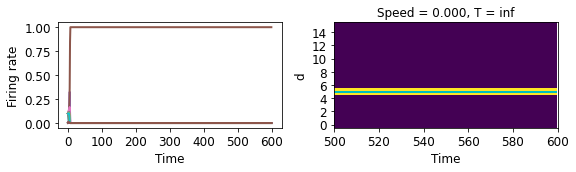

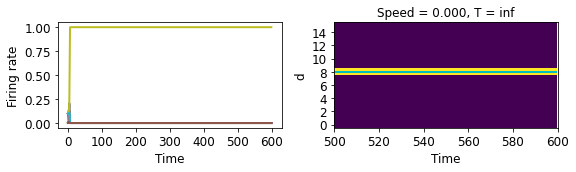

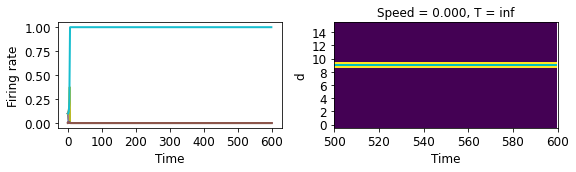

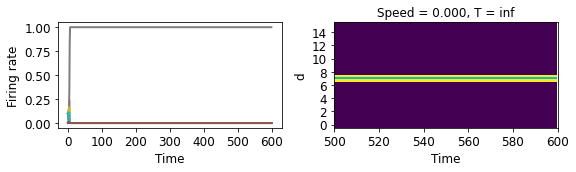

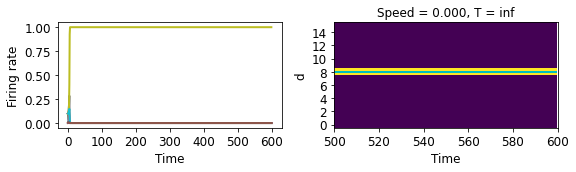

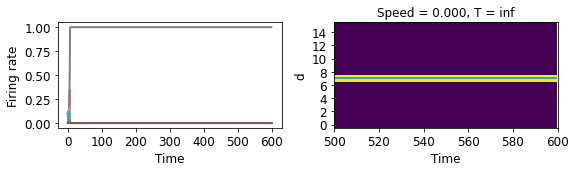

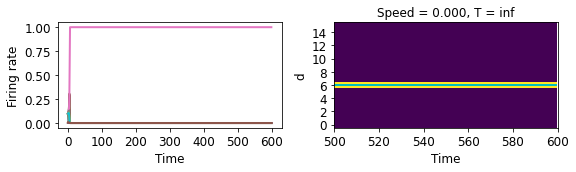

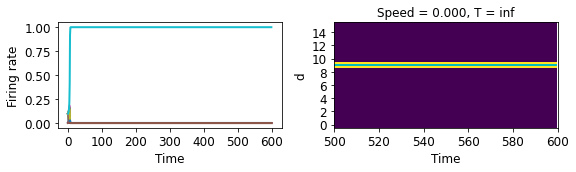

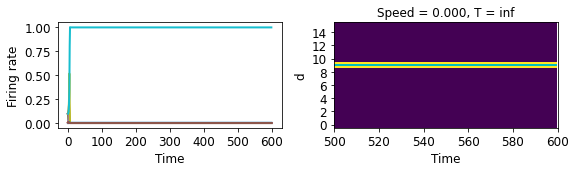

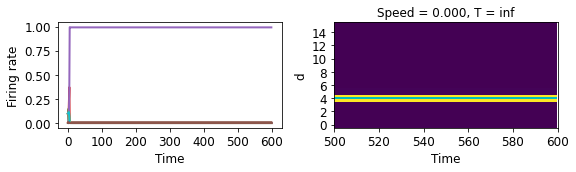

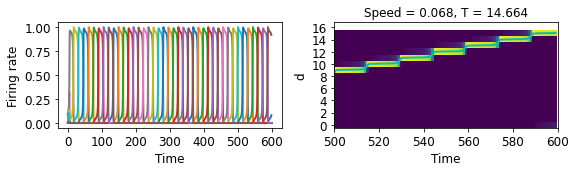

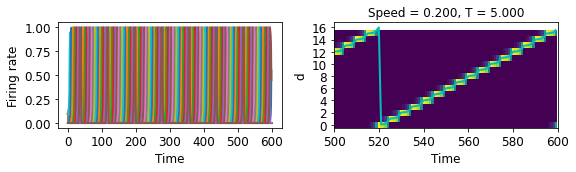

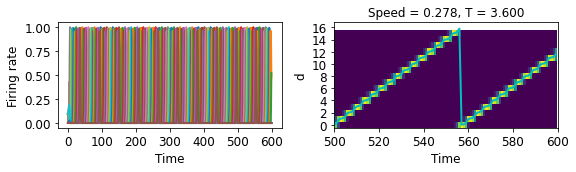

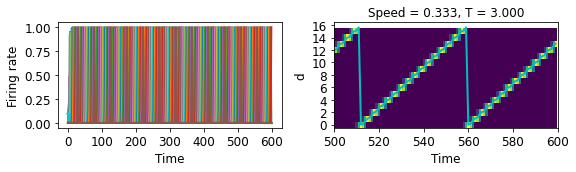

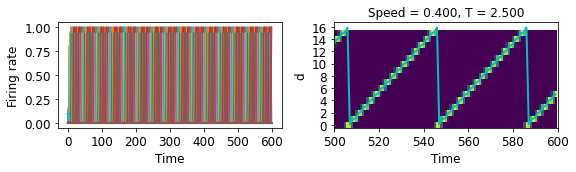

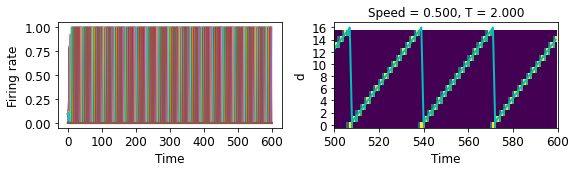

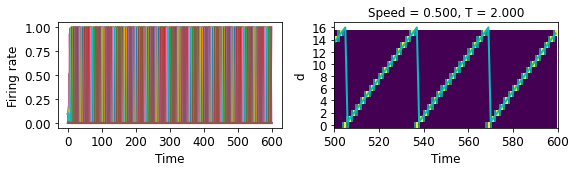

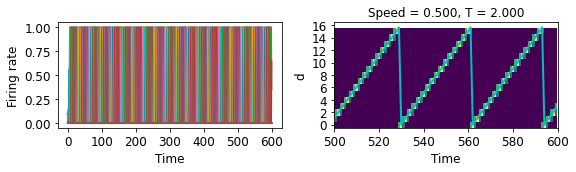

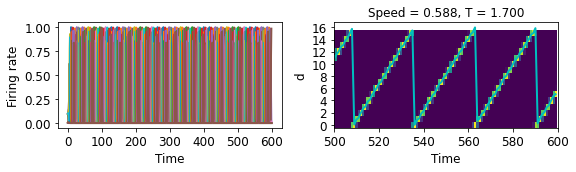

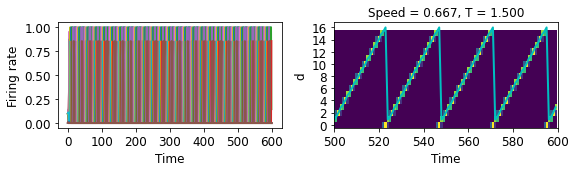

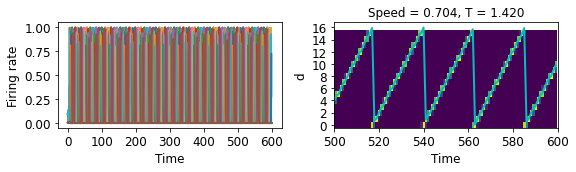

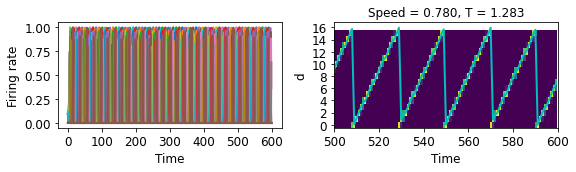

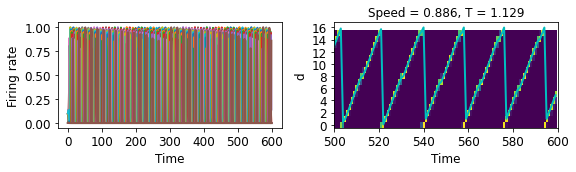

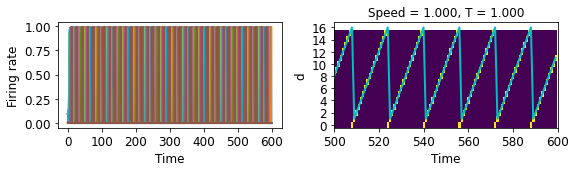

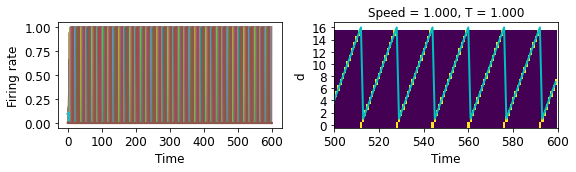

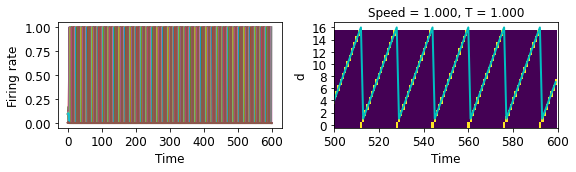

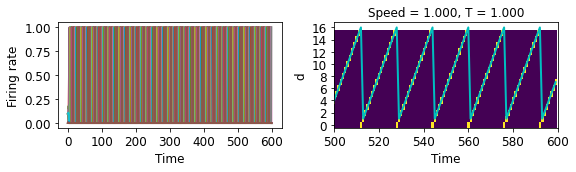

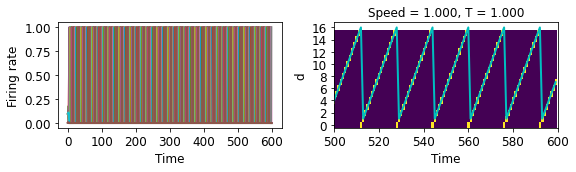

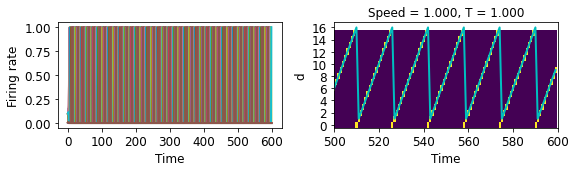

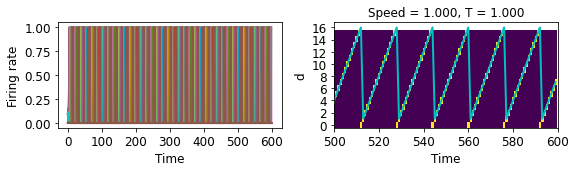

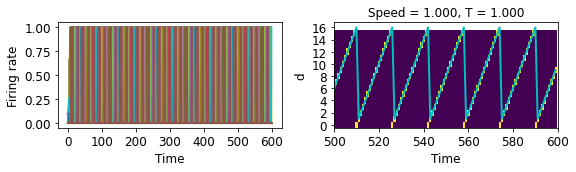

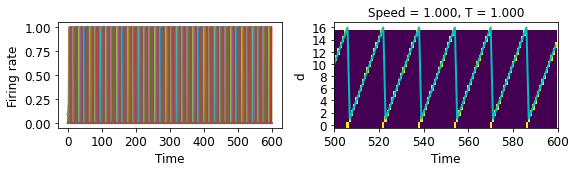

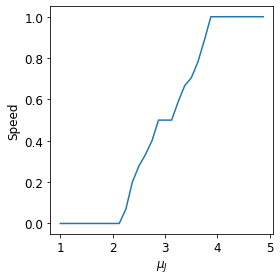

In [7]:
for ths, c_mean, spd in zip(ths_all, c_means, spds):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)
    
    axs[0].plot(ths, lw=2)
    set_plot(axs[0], x_label='Time', y_label='Firing rate')
    
    axs[1].matshow(ths.T, origin='lower')
    axs[1].set_aspect('auto')
    axs[1].plot((c_mean % (2*np.pi))*D/(2*np.pi), c='c', lw=2)
    
    axs[1].xaxis.tick_bottom()
    set_plot(axs[1], x_lim=(t_max-100, t_max), x_label='Time', y_label='d', title=f'Speed = {spd:.3f}, T = {1/spd:.3f}')


fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.plot(MU_J_SEQS, spds)

set_plot(ax, x_label=f'$\mu_J$', y_label='Speed')

In [8]:
np.save('data/seq_speed/seqs_md_mft.npy', np.array([{
    'MU_J_SEQS': MU_J_SEQS,
    'spds': spds,
    'ths_all': ths_all,
}]))

# Variance-driven sequence network (starting from variance self-coupled network)

In [9]:
MU_J_SELF = 0
MU_J_CROSS = 0
MU_J_SEQ = 0

SGM_J_SELF = 10
SGM_J_CROSS = 1
SGM_J_SEQS = np.arange(1, 17, .5)

ths_all = []

for SGM_J_SEQ in SGM_J_SEQS:
    sys.stdout.write('.')

    MU_J = np.nan*np.zeros((D, D))
    SGM_J = np.nan*np.zeros((D, D))

    MU_J[mself] = MU_J_SELF
    MU_J[~mself] = MU_J_CROSS
    MU_J[mseq] = MU_J_SEQ

    SGM_J[mself] = SGM_J_SELF
    SGM_J[~mself] = SGM_J_CROSS
    SGM_J[mseq] = SGM_J_SEQ

    th_0 = .05*np.random.rand(D)
    th_0[:10] += 1
    th_0 /= th_0.sum()

    ths = np.nan*np.zeros((t_max, D))
    ths[0, :] = th_0

    for t_ in t[1:]:
        ths[t_, :] = alph(ths[t_-1, :], u=0, v=0, D=D, mu_j=MU_J, sgm_j=SGM_J)
        
    ths_all.append(ths)

................................

In [10]:
# estimate speeds
t_start = 200
c_means = [get_c_mean_p(A, ths) for ths in ths_all]
spds = [get_c_spd(c_mean, t_start)*D/(2*np.pi) for c_mean in c_means]

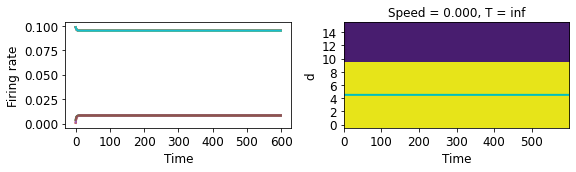

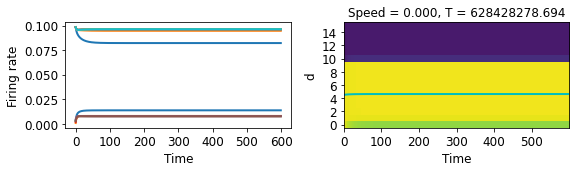

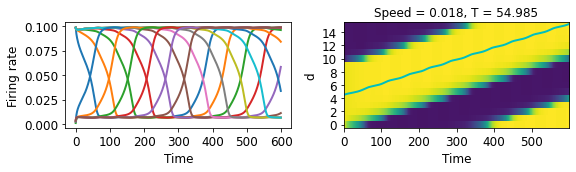

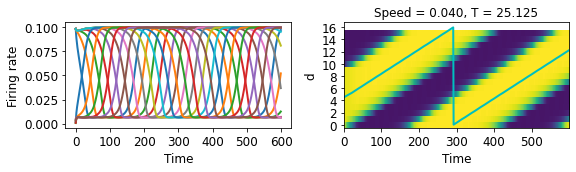

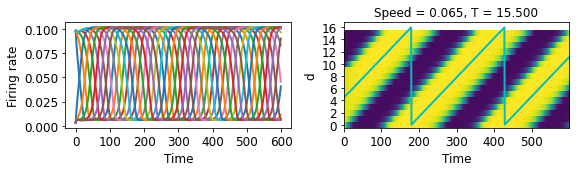

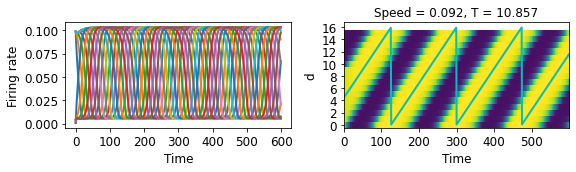

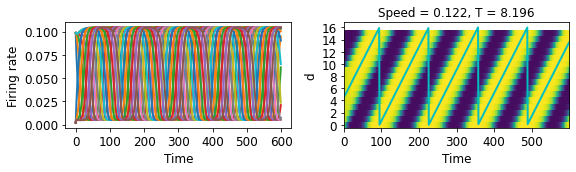

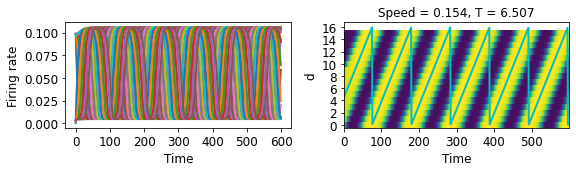

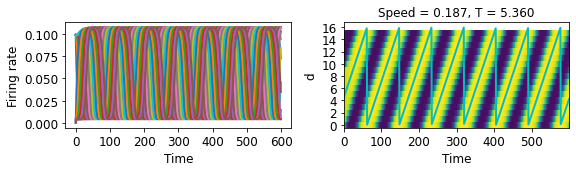

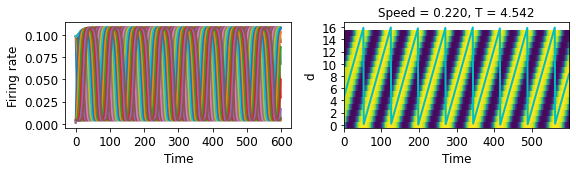

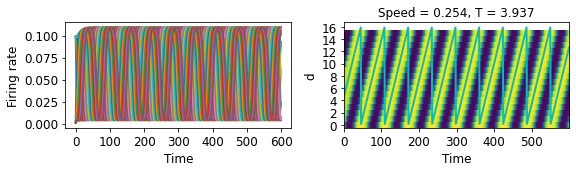

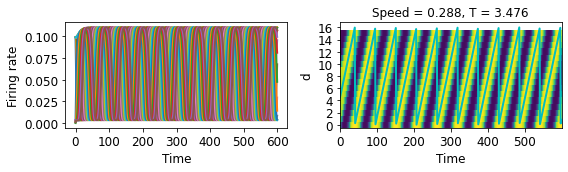

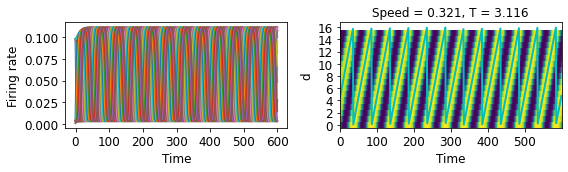

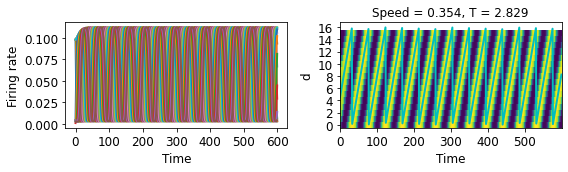

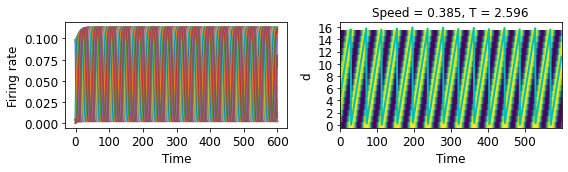

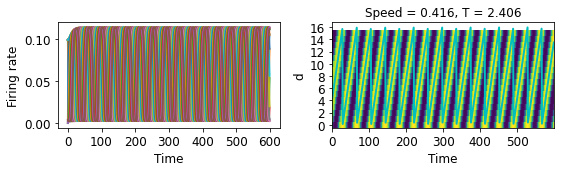

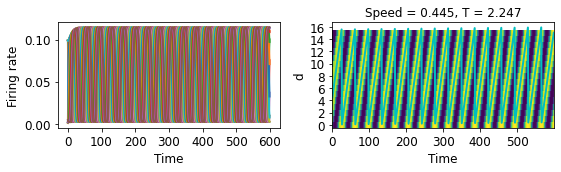

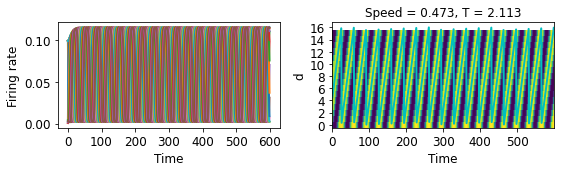

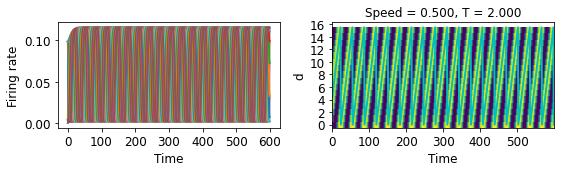

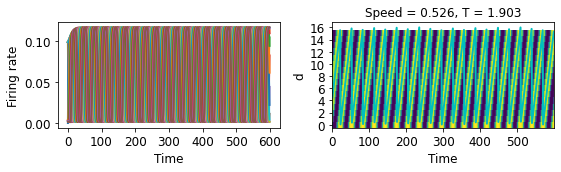

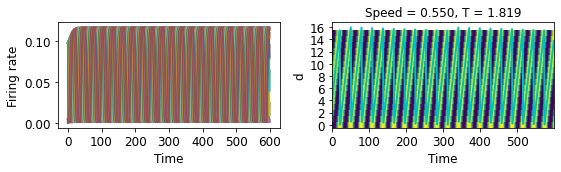

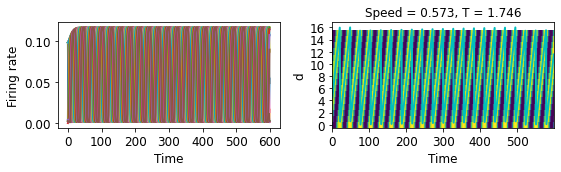

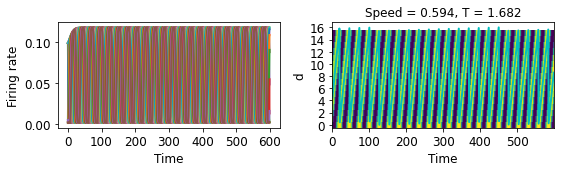

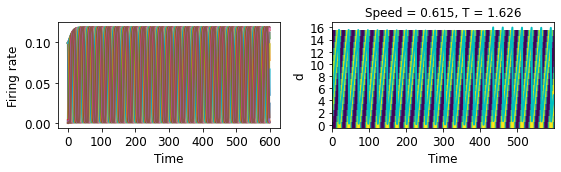

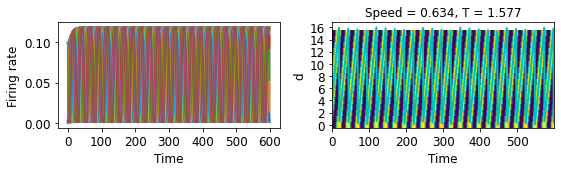

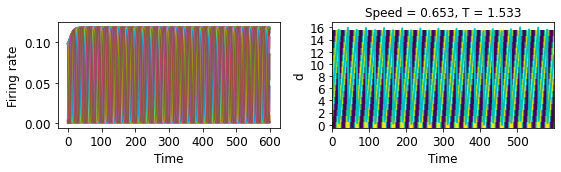

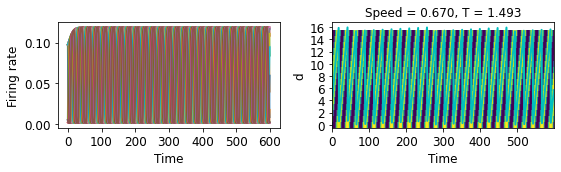

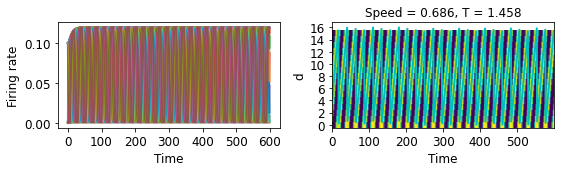

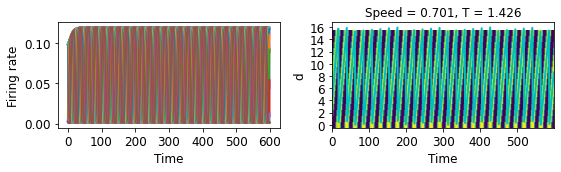

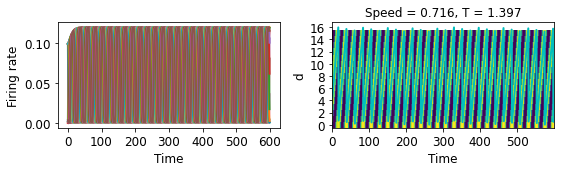

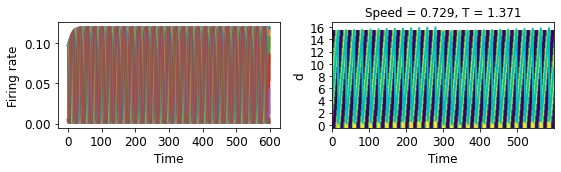

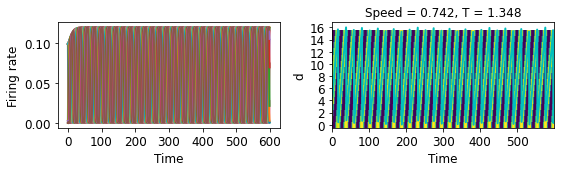

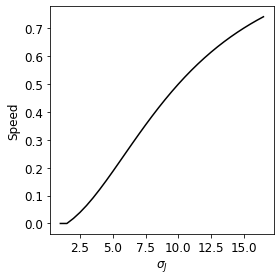

In [11]:
for ths, c_mean, spd in zip(ths_all, c_means, spds):
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5), tight_layout=True)
    
    axs[0].plot(ths, lw=2)
    set_plot(axs[0], x_label='Time', y_label='Firing rate')
    
    axs[1].matshow(ths.T, origin='lower')
    axs[1].set_aspect('auto')
    axs[1].plot((c_mean % (2*np.pi))*D/(2*np.pi), c='c', lw=2)
    
    axs[1].xaxis.tick_bottom()
    set_plot(axs[1], x_label='Time', y_label='d', title=f'Speed = {spd:.3f}, T = {1/spd:.3f}')


fig, ax = plt.subplots(1, 1, figsize=(4, 4), tight_layout=True)
ax.plot(SGM_J_SEQS, spds, c='k')

set_plot(ax, x_label=f'$\sigma_J$', y_label='Speed')

In [12]:
np.save('data/seq_speed/seqs_fd_mft.npy', np.array([{
    'SGM_J_SEQS': SGM_J_SEQS,
    'spds': spds,
    'ths_all': ths_all,
}]))